## 1. Building a defect system

### the `DefectChargeState` object

Let's take the example of NaCl, a rocksalt structured material, and assume the only
defects that can form are vacancies, we have two "defect species", $V_\mathrm{Na}$
and $V_\mathrm{Cl}$, each vacancy is assumed to have two possible charge states, $V^{0}_\mathrm{Na}$ and $V^{-1}_\mathrm{Na}$ and $V^{0}_\mathrm{Cl}$ and $V^{+1}_\mathrm{Cl}$.

In [63]:
from py_sc_fermi.defect_charge_state import DefectChargeState

v_Na_0 = DefectChargeState(charge= 0, # the charge of the defect
                           degeneracy= 1, # see "note on spin degeneracy" at the bottom of this notebook
                           energy = 1.0 # defect formation energy in eV, we will just use a dummy value here
)

v_Na_minus_1 = DefectChargeState(charge= -1, degeneracy= 1, energy = 2.0)

# repeat for the Cl vacancy

v_Cl_0 = DefectChargeState(charge= 0, degeneracy= 1, energy = 1.0)
v_Cl_1 = DefectChargeState(charge= 1, degeneracy= 1, energy = -1.0)


### the `DefectSpecies` object

The `DefectSpeices` object collects `DefectChargeStates` together under a single
"kind" of defect, this is useful for assinging consistent site degeneracies (and specifiying different constraints, which we will come to later). These are defined like so:

In [64]:
from py_sc_fermi.defect_species import DefectSpecies

# defining the Na vacancy

v_Na = DefectSpecies(name = "v_Na", # the name can be any string, it only needs to be unique in the set of all species
                    nsites = 1, # the number of sites on which the defect can form in the unit cell (see usage notes)
                    charge_states = {0 : v_Na_0, -1: v_Na_minus_1}) # dictionary of charge states, with the key being the charge and the value being the corresponding DefectChargeState object

# defining the Cl vacancy

v_Cl = DefectSpecies(name = "v_Cl", nsites = 1, charge_states = {0 : v_Cl_0, 1: v_Cl_1})

### the `DOS` obeject

The `DOS` object contains the density of states information calculated for the 
unit cell (see usage notes in the documentation for a strict definintion of the unit cell)
we take data calculated from the [Materials Project](https://materialsproject.org/) for NaCl
([mp-22862](https://materialsproject.org/materials/mp-22862)) which we have dumped into a csv file.

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from py_sc_fermi.dos import DOS

energy = np.loadtxt('dos.csv', delimiter=',')[0] # the energy range of the DOS information
dos = np.loadtxt('dos.csv', delimiter=',')[1] # the (total) DOS

dos = DOS(dos = dos,      # 
          edos = energy,  # 
          bandgap = 5,    # the bandgap in eV (taken from the Materials Project, mp-22862)
          nelect = 20,    # TODO: check this number
          spin_polarised=False) # This dos calculation is not spin polarised

### the `DefectSystem` object

The `DefectSystem` object collects our `DefectSpecies` together, and allows for us to search for the self-consistent Fermi energy. It is defined as below:

In [66]:
from py_sc_fermi.defect_system import DefectSystem

defect_system = DefectSystem(defect_species = [v_Na, v_Cl], # list of py_sc_fermi.defect_species.DefectSpecies objects
             dos = dos, # py_sc_fermi.dos.DOS object
             volume = 46.10, # the volume of the unit cell in angstrom^3 (taken from the Materials Project, mp-22862)
             temperature = 500) # the temperature in K

`defect_system.report()` will print a summary of the solved defect system
including the the defect concentrations and the self-consistent Fermi energy

In [67]:
defect_system.report()

SC Fermi level :      1.5000000000000888  (eV)
Concentrations:
n (electrons)  : 3.9275293083444446e-18 cm^-3
p (holes)      : 816810.0179280476 cm^-3
v_Na           : 1.979360284643525e+17 cm^-3
v_Cl           : 1.9793602846353648e+17 cm^-3

Breakdown of concentrations for each defect charge state:
---------------------------------------------------------
v_Na       : Charge Concentration(cm^-3) Total
           :  0  1.806104e+12          0.00 
           : -1  1.979342e+17          100.00 
---------------------------------------------------------
v_Cl       : Charge Concentration(cm^-3) Total
           :  0  1.806104e+12          0.00 
           :  1  1.979342e+17          100.00 



/Users/alex/work/py_sc_fermi_example/py-sc-fermi/py_sc_fermi/dos.py:198: RuntimeWarning: overflow encountered in exp
  + np.exp(
/Users/alex/work/py_sc_fermi_example/py-sc-fermi/py_sc_fermi/dos.py:207: RuntimeWarning: overflow encountered in exp
  + np.exp((self.edos[self._n0_index() :] - e_fermi) / (kboltz * temperature))


## 2. Misc. `DefectSystem` analysis

There are various analyses we can perform once our defect system is defined, some
non-exhaustive examples are included in the cells below:

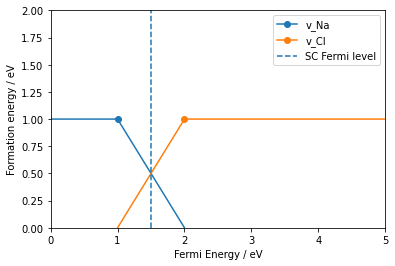

In [68]:
# plot transtition levels

# get a dictonary of the lines for a transition level (TL) digram where the key is the name of the DefectSpecies 
# the values is a list of lists, where the first list is the x coordiantes of the TL profile and the second list
# is the y coordinates of the TL profile
transition_levels = defect_system.get_transition_levels() 

# get the self consistent Fermi energy to plot on the TL diagram
sc_fermi = defect_system.get_sc_fermi()[0]

# plot each defect species TL profile on the full diagram, and label as 
# the defect species name
for k, v in transition_levels.items():
    plt.plot(v[0], v[1], "-o", label=k)

# plot the self consistent Fermi energy
plt.vlines(sc_fermi, 0, 2, linestyles="dashed", label = "SC Fermi level")

plt.ylim(0, 2)
plt.xlim(0, 5)
plt.legend()
plt.ylabel("Formation energy / eV")
plt.xlabel("Fermi Energy / eV")
plt.show()

Text(0.5, 0, 'Fermi Energy / eV')

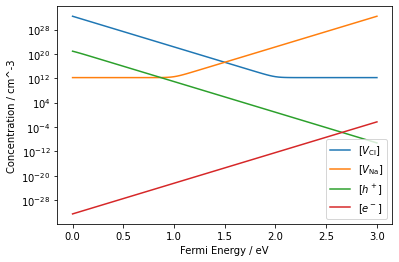

In [69]:
# plot defect charge concentrations as a function of Fermi energy

fermi_energies = np.linspace(0, 3, 100)

# plot the concentrations of the defects as a function of Fermi energy

v_Cl_conc = []
v_Na_conc = []
for e_fermi in fermi_energies:
    v_Cl_conc.append(v_Cl.get_concentration(e_fermi, 500) * 1e24 / defect_system.volume)
    v_Na_conc.append(v_Na.get_concentration(e_fermi, 500) * 1e24 / defect_system.volume)

plt.plot(fermi_energies, v_Cl_conc, label="$[V_\mathrm{Cl}]$")
plt.plot(fermi_energies, v_Na_conc, label="$[V_\mathrm{Na}]$")
plt.yscale("log")

# plot the concentration of electrons as a function of Fermi energy

h_conc = []
e_conc = []
for e_fermi in fermi_energies:
    h_conc.append(dos.carrier_concentrations(e_fermi, 500)[0] * 1e24 / defect_system.volume)
    e_conc.append(dos.carrier_concentrations(e_fermi, 500)[1] * 1e24 / defect_system.volume)

plt.plot(fermi_energies, h_conc, label="$[h^+]$")
plt.plot(fermi_energies, e_conc, label="$[e^-]$")
plt.legend()

plt.ylabel("Concentration / cm^-3")
plt.xlabel("Fermi Energy / eV")

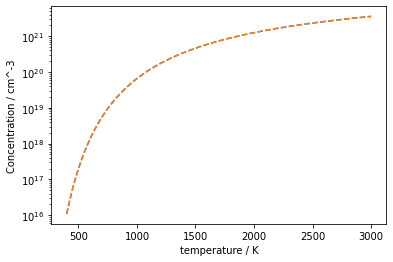

In [76]:
# plot the defect concentration as a function of temperature

temperatures = np.linspace(400, 3000, 100)

v_Cl_conc = []
v_Na_conc = []
for t in temperatures:
    ds = defect_system.temperature = t
    concentrations = defect_system.as_dict()
    v_Cl_conc.append(concentrations["v_Cl"])
    v_Na_conc.append(concentrations["v_Na"])

plt.plot(temperatures, v_Cl_conc, label="$[V_\mathrm{Cl}]$", ls = "--")
plt.plot(temperatures, v_Na_conc, label="$[V_\mathrm{Na}]$", ls = "--")
plt.yscale("log")

plt.ylabel("Concentration / cm^-3")
plt.xlabel("temperature / K")
plt.show()

## 3. Applying concentration constraints

### fixing the concentrations of `DefectSpecies`

There are a range of constraints we can apply to the concentrations of the defects in 
a `DefectSystem`, the first example is to fix the concentration of the `DefectSpecies`. 
This is purely a thought experiment, but may represent a system where barriers for
ionic motion are very large, but electronic transport is facile. Here we will look at
what happens to the hole concentration if we run our NaCl system at high temperatures, 
then rerun at low temperatures. 

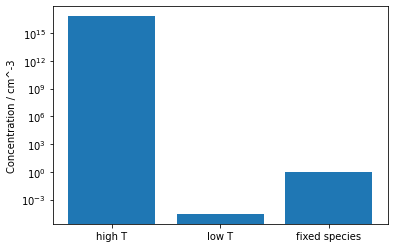

In [109]:
from copy import deepcopy

# make a copy of the main defect system
live_defect_system = deepcopy(defect_system)

# calculate defect and electronic carrier concentrations at high T.
live_defect_system.temperature = 1500
high_t_defects = live_defect_system.as_dict()

# repeat at low T
low_t_defect_system = deepcopy(defect_system)
low_t_defect_system.temperature = 300
low_t_defects = low_t_defect_system.as_dict()

# fix the concentration of the defect species at high T, and then 
# calculate the concentration of the electron holes at low T
fixed_species_defect_system = deepcopy(defect_system)
fixed_species_defect_system.temperature = 300
fixed_species_defect_system.defect_species_by_name("v_Na").fix_concentration(high_t_defects["v_Na"] / 1e24 * defect_system.volume)
fixed_species_defect_system.defect_species_by_name("v_Cl").fix_concentration(high_t_defects["v_Cl"] / 1e24 * defect_system.volume)
fixed_species_defects = fixed_species_defect_system.as_dict()

# plot the results
plt.bar([0, 1, 2],  [high_t_defects["p0"], low_t_defects["p0"], fixed_species_defects["p0"]])
plt.xticks([0, 1, 2], ["high T", "low T", "fixed species"])
plt.ylabel("Concentration / cm^-3")
plt.yscale("log")

We find the hole concentration in the fixed system (high temperature defect concentrations with electrons and holes recalculated at lower temperatures) is inflated relative to the low temperature system. 

### fixing the concentrations of `DefectChargeStates`
What about if we have a system where we imagine neither ionic defects or their charge states can requilibrate on the timescale of interest, here we take high temperature charged defects and fix their concentrations, rerunning at lower temperatures, and find this time, that the hole concetnration in the system with fixed concentration charge states ~ to the system calculated at high temperatures.

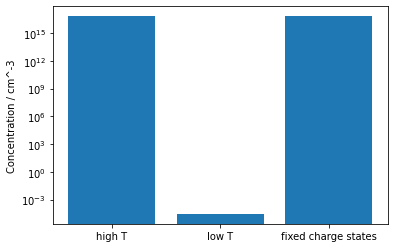

In [110]:
# make a copy of the main defect system
live_defect_system = deepcopy(defect_system)

# calculate defect and electronic carrier concentrations at high T.
live_defect_system.temperature = 1500
high_t_defects = live_defect_system.as_dict(decomposed=True)

# repeat at low T
low_t_defect_system = deepcopy(defect_system)
low_t_defect_system.temperature = 300
low_t_defects = low_t_defect_system.as_dict(decomposed=True)

# fix the concentration of the defect species at high T, and then 
# calculate the concentration of the electron holes at low T
fixed_species_defect_system = deepcopy(defect_system)
fixed_species_defect_system.temperature = 300
fixed_species_defect_system.defect_species_by_name("v_Na").charge_states[-1].fix_concentration(high_t_defects["v_Na"][-1] / 1e24 * defect_system.volume)
fixed_species_defect_system.defect_species_by_name("v_Cl").charge_states[1].fix_concentration(high_t_defects["v_Cl"][1] / 1e24 * defect_system.volume)
fixed_species_defects = fixed_species_defect_system.as_dict()

plt.bar([0, 1, 2],  [high_t_defects["p0"], low_t_defects["p0"], fixed_species_defects["p0"]])
plt.xticks([0, 1, 2], ["high T", "low T", "fixed charge states"])
plt.ylabel("Concentration / cm^-3")
plt.yscale("log")

### introducing an additional fixed concentration defect

Finally, we can introduce an additional defect to model how the defect concentrations
will respond to e.g. the introduction of a charged dopant. 

/Users/alex/work/py_sc_fermi_example/py-sc-fermi/py_sc_fermi/dos.py:198: RuntimeWarning: overflow encountered in exp
  + np.exp(
/Users/alex/work/py_sc_fermi_example/py-sc-fermi/py_sc_fermi/dos.py:207: RuntimeWarning: overflow encountered in exp
  + np.exp((self.edos[self._n0_index() :] - e_fermi) / (kboltz * temperature))


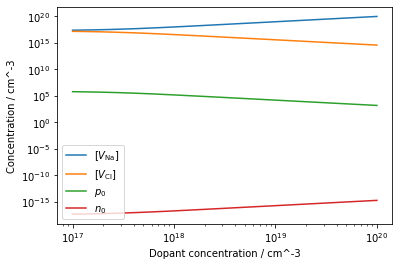

In [121]:
dopant_concentrations = np.logspace(17,20)

v_Na_conc = []
v_Cl_conc = []
p_0 = []
n_0 = []
for dopant_concentration in dopant_concentrations:
    dopant_charge_state = DefectChargeState(1, fixed_concentration = dopant_concentration / 1e24 * defect_system.volume)
    dopant_species = DefectSpecies("dopant", 1, charge_states = {1 : dopant_charge_state})
    live_defect_system = DefectSystem(defect_species = [dopant_species, v_Na, v_Cl], volume = defect_system.volume, temperature = 500, dos = defect_system.dos)
    defect_data = live_defect_system.as_dict()
    v_Na_conc.append(defect_data["v_Na"])
    v_Cl_conc.append(defect_data["v_Cl"])
    p_0.append(defect_data["p0"])
    n_0.append(defect_data["n0"])

plt.plot(dopant_concentrations, v_Na_conc, label="$[V_\mathrm{Na}]$")
plt.plot(dopant_concentrations, v_Cl_conc, label="$[V_\mathrm{Cl}]$")
plt.plot(dopant_concentrations, p_0, label="$p_0$")
plt.plot(dopant_concentrations, n_0, label="$n_0$")


plt.ylabel("Concentration / cm^-3")
plt.xlabel("Dopant concentration / cm^-3")
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()